# AnoPatchCore

* 근본 가정이었던, Anomaly Feature와 Normal Feature와의 상관관계를 확인하고자 함

In [1]:
import sys
import torch
import torch.nn.functional as F
sys.path.append('/home/mjuny/workspace/anomalib/src')

from anomalib.models import get_model
from anomalib.data import get_datamodule
from anomalib.config import get_configurable_parameters
from anomalib.models.components import KCenterGreedy

from matplotlib import pyplot as plt
from tqdm import tqdm

/home/mjuny/anaconda3/envs/anomalib_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:1'
model_name = 'patchcore'
config_path = '/home/mjuny/workspace/anomalib/src/anomalib/models/padim/patchcore.yaml'
shuffle_memory_bank = False

config = get_configurable_parameters(model_name=model_name, config_path=config_path)

model = get_model(config)
model.to(device)

/home/mjuny/workspace/anomalib/src/anomalib/config/config.py:280: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(
/home/mjuny/anaconda3/envs/anomalib_env/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


PatchcoreLightning(
  (image_threshold): AnomalyScoreThreshold()
  (pixel_threshold): AnomalyScoreThreshold()
  (model): PatchcoreModel(
    (feature_extractor): FeatureExtractor(
      (feature_extractor): FeatureListNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): ReLU(inplace=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

In [3]:
def _mask_to_weight(input_mask, size = [28, 28]):
            mask_patch = F.interpolate(input_mask, size=size)
            mask_patch = mask_patch.reshape(1, -1).squeeze()

            
            weights = torch.tensor([0 for _ in range(mask_patch.shape[-1])])
            weights[mask_patch > 0.33] = 1
            weights[mask_patch > 0.66] = 2
            
            return weights

def feature_extract(model, item):
    image_batch = torch.unsqueeze(item['image'], dim=0).to(device)
    mask_batch = torch.unsqueeze(item['mask'], dim=0).to(device)

    features = model.model.feature_extractor(image_batch)
    embedding = model.model.generate_embedding(features)

    batch_size, _, width, height = embedding.shape
    embedding = model.model.reshape_embedding(embedding)
    weights = _mask_to_weight(torch.unsqueeze(mask_batch, dim=1), features[list(features.keys())[0]].shape[-2:])

    return embedding, weights

def euclidean_dist(x, y):
    """
    Calculates pair-wise distance between row vectors in x and those in y.

    Replaces torch cdist with p=2, as cdist is not properly exported to onnx and openvino format.
    Resulting matrix is indexed by x vectors in rows and y vectors in columns.

    Args:
        x: input tensor 1
        y: input tensor 2

    Returns:
        Matrix of distances between row vectors in x and y.
    """
    x_norm = x.pow(2).sum(dim=-1, keepdim=True)  # |x|
    y_norm = y.pow(2).sum(dim=-1, keepdim=True)  # |y|
    # row distance can be rewritten as sqrt(|x| - 2 * x @ y.T + |y|.T)
    res = x_norm - 2 * torch.matmul(x, y.transpose(-2, -1)) + y_norm.transpose(-2, -1)
    res = res.clamp_min_(0).sqrt_()
    return res

prepare dataset

In [4]:
datamodule = get_datamodule(config)
train_dataset = datamodule.train_data
train_dataset._setup()

test_dataset = datamodule.test_data
test_dataset._setup()

## extract features

select one of train / test_dataset

In [5]:
target_dataset = train_dataset
# target_dataset = test_dataset

normal_features = []
normal_weights = []

abnormal_features = []
abnormal_weights = []

total_weights = []
cntAnomalyImage = 0
for idx, item in tqdm(enumerate(target_dataset)):
    feature, weight = feature_extract(model, item)
    # feature.to(device)
    # weight.to(device)

    normal_features.append(feature[weight == 0])
    normal_weights.append(weight[weight == 0])
    abnormal_features.append(feature[weight != 0])
    abnormal_weights.append(weight[weight != 0])
    total_weights.append(weight)

    if weight.sum(): #Anomaly Image cnt
        cntAnomalyImage += 1    

209it [00:05, 35.94it/s]


* feat: visualize some images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


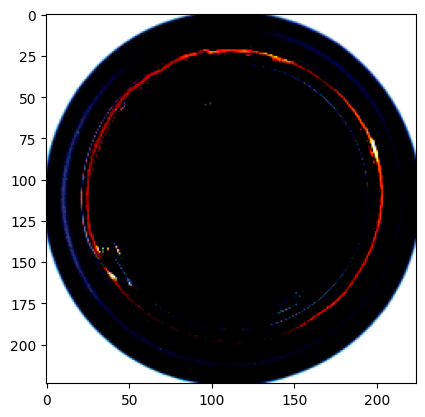

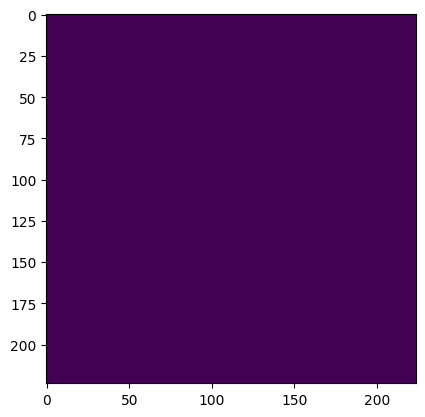

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [6]:
target_idx = 2

plt.imshow(target_dataset[target_idx]['image'].permute(1, 2, 0))
plt.show()
plt.imshow(target_dataset[target_idx]['mask'])
plt.show()

for idx, w in enumerate(total_weights[target_idx]):
    print(f'{w} ', end='')
    if (idx + 1) % 28 == 0:
        print()

## coreset sampling from features

In [7]:
normal_embedding = torch.vstack(normal_features)
normal_weight_concat = torch.hstack(normal_weights)

abnormal_embedding = torch.vstack(abnormal_features)
abnormal_weight_concat = torch.hstack(abnormal_weights)

sampler = KCenterGreedy(embedding=normal_embedding, sampling_ratio=0.1)
coreset, idxs = sampler.sample_coreset()

# add anomaly feature in memory bank
if shuffle_memory_bank:
    memory_bank = torch.cat((coreset, abnormal_embedding), 0)
    feature_indices = torch.cat((torch.tensor([0 for _ in range(len(coreset))]), abnormal_weight_concat), 0)
else:
    memory_bank = coreset
    feature_indices = torch.tensor([0 for _ in range(len(coreset))])


Selecting Coreset Indices.: 100%|██████████| 16385/16385 [00:20<00:00, 802.28it/s]


## cal Distance from coreset with inference features

In [8]:
for idx, item in tqdm(enumerate(test_dataset)):
    inference_feature, weight = feature_extract(model, item)
    print(item['label'], item['mask'].sum()) #label 1: anomaly, 0: normal
    break

inference_feature.shape

0it [00:00, ?it/s]

1 tensor(7130., dtype=torch.float64)


torch.Size([784, 1536])

In [9]:
distances = euclidean_dist(inference_feature, memory_bank)
# peak top 9 features
patch_scores, locations = distances.topk(k=9, largest=False, dim=1)

batch_size = 1
patch_scores = patch_scores.reshape((batch_size, -1))
batch_size, num_patches = patch_scores.shape
patch_scores.shape
# shape: (patch_nums{28 * 28}, nearest 9)

torch.Size([1, 7056])

In [10]:
# 1. Find the patch with the largest distance to it's nearest neighbor in each image
max_patches = torch.argmax(patch_scores, dim=1)  # indices of m^test,* in the paper
max_patches.shape

max_patches_features = inference_feature.reshape(batch_size, num_patches, -1)[torch.arange(batch_size), max_patches]

RuntimeError: shape '[1, 7056, -1]' is invalid for input of size 1204224

In [11]:
inference_feature.reshape(1, 784, -1)[0, max_patches]

../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [2,0,0], thread: [32,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [2,0,0], thread: [33,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [2,0,0], thread: [34,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [2,0,0], thread: [35,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [2,0,0], thread: [36,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [2,0,0], thread: [37,0,0] Assertion `-sizes[i] <

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [34]:
# m^test,* in the paper
max_patches_features = inference_feature.reshape(1, 784, -1)[torch.arange(1), max_patches]

max_patches_features.shape

torch.Size([784, 1536])

In [36]:
inference_feature.shape

torch.Size([784, 1536])

In [19]:
len(locations), locations[0]

(784,
 tensor([   1, 1871, 2798,  519,  157,  312, 8484, 8104, 6700], device='cuda:1'))

In [55]:
weight_concat = torch.hstack(weights)
weight_concat.shape

torch.Size([173264])

In [52]:
len(weights)

221